# Price Interest Rate Swaps

1. Get quarterly LIBOR rate: 3m,6m,9m,12m;
2. Using quarterly libor rates to subtract 10bps to get OIS
3. Get Swap rate, which is used to calculate coupon (# From the website).# 1y,2y,3y,5y,7y,10y,30y
4. Using interplotation method, we could get swap rate like in 1.5 years. 

5. Bootstraping zero curves by LIBOR and SWAP rate( Bond principal,(Par value), time to maturity, coupon)

One year swap rate is 0.23%, so the coupon is 100*


In [1]:
import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy.linalg as npl
import matplotlib.pyplot as plt
from scipy.optimize import fmin_bfgs
import scipy.optimize
from scipy.optimize import minimize

In [2]:
### preprocessing of the input data 
df_Libor = pd.read_csv('ICELiborHistoricalRates (1).csv')
df_Libor.drop('Publication Time',axis='columns', inplace=True)

df_swap = pd.read_excel('SwapRate.xlsx')
### Using interpolation method to get the libor rate on 9 months
df_Libor.loc[7] = ['12 Month', float(df_Libor.iloc[[-1],[1]].values) ]
month_9 = (df_Libor.iloc[[-1],[1]].values - df_Libor.iloc[[-3],[1]].values)*0.5 + df_Libor.iloc[[-3],[1]].values
df_Libor.loc[6] = ['9 Month', month_9] 
df_Libor = df_Libor.rename(columns = {'USD ICE LIBOR 23-Nov-2020': 'LIBOR'}, inplace = False)
df_Libor = df_Libor.iloc[-4:,]
df_Libor['LIBOR'] = df_Libor['LIBOR'] /100
Libor = df_Libor['LIBOR'].tolist()

ZR_ts = [0.25, 0.5, 0.75, 1]
ZRs = Libor
swap_ts = df_swap['Time'].tolist()
SwapRates = df_swap['SwapRate'].tolist()


In [10]:
df_Libor

,Tenor,LIBOR
4,3 Month,0.002065
5,6 Month,0.002537
6,9 Month,0.002947
7,12 Month,0.003356


In [3]:
class IRSPricer(): 
    def __init__(self,  swapRate, tfrac=0.25, maturity=5, Notional=100):
        ## Two cases: 
        # Case 1:  swapID, 0: a newly issued swap, swapRate is to be calculated
        # Case 2:  swapID, 0: An already issued swap, price and sensitivity is to be caculated
   
        self.swapRate = swapRate
        self.Notional = Notional
        self.tfrac = tfrac
        self.maturity = maturity

        
    def Curves(self, ZR_ts, ZRs, swap_ts, SwapRates, PayFre=4, SwapNotional=100):
        # build a complete zero curves from time zero
        # assuming the input as follows: 
             #   ZR_ts and ZRs are the maturity (in year) and zero rates of short maturity 
             #   (e.g. Zr_ts is an array of 0.25, 0.5, 0.75, 1, and ZRs have the corresponding zero r
        #    swap_ts and SwapRates are the swap time and swapRates
        #        The ZR_ts and swap_ts must have the same frequency and swap_ts follows ZR_ts, 
             #   so that together they cover a complete period  
        ###  The aim of the function is to build a zero rate curve covering the whole period of ZR_ts + swap_ts
        ZR_Ps = len(ZR_ts) 
        swap_Ps = len(swap_ts)
        Total_Ps = ZR_Ps + swap_Ps
        TotalZRs = np.zeros((Total_Ps,3))  # col 0: time, col 1 : SwapRate, col 2: zero rate

        TotalZRs[0:ZR_Ps,0] = ZR_ts
        TotalZRs[ZR_Ps:,0] = swap_ts
        TotalZRs[0:ZR_Ps,2] = ZRs
        TotalZRs[ZR_Ps:,1] = SwapRates

        for i in range(ZR_Ps, Total_Ps):
            sr = TotalZRs[i,1]
            zrs = TotalZRs[0:i,2]
            ts = TotalZRs[0:i,0]
            ti = TotalZRs[i,0]

            PayTs = len(ts)
            Pays = PayTs * [0]
            Pays[-1] = SwapNotional
            cpn = sr / PayFre * SwapNotional ## coupon
            paymentsBefore = cpn * np.exp(- zrs * ts) # sum 
            PaysBeforeSum = np.sum(paymentsBefore)
            finalP = SwapNotional + cpn 

            zeroRate = - np.log((SwapNotional - PaysBeforeSum) / finalP) / ti
            TotalZRs[i,2] = zeroRate          
            
        self.Ts = TotalZRs[:,0]
        self.ZRates = TotalZRs[:,2]
        self.OIS = TotalZRs[:,2] - 0.001 # assume that the OIS rate is 10 basis point below the zero rates
        self.DFs = np.exp(-self.Ts * self.OIS)
        
    def calSwapValue(self):
        NPVFloat = self.FloatingLeg() 
        NPVFixed = self.FixedLeg()
        
        NPV =  NPVFloat - NPVFixed
        return NPV

        
    def FloatingLeg(self):
        tfrac = self.tfrac
        maturity = self.maturity
        ZRates = self.ZRates
        Notional = self.Notional
        DFs = self.DFs
        Ts = self.Ts
        NrPs = int(maturity / tfrac)
        ZeroRateDFs = np.exp(- ZRates * Ts)
        RatesTs = ZRates * Ts
        FloatRates = (ZeroRateDFs[:-1] / ZeroRateDFs[1:] - 1 ) /tfrac
        FloatRates = np.insert(FloatRates, 0, ZRates[0])
        FloatCashFlow = Notional * FloatRates[:NrPs] * tfrac
        DiscountFloatCashFlow = FloatCashFlow * DFs[:NrPs]
        NPVFloat = np.sum(DiscountFloatCashFlow)
        self.FloatRates = FloatRates
        
        return NPVFloat
    
        
    def DetermineAmortizingNotional(self):
        tfrac = self.tfrac
        maturity = self.maturity
        NrPs = int(maturity / tfrac)
        Notional = self.Notional 
        Notionals = np.linspace(Notional, Notional / NrPs, NrPs)
        self.Notional = Notionals
        
        return Notionals
    
    def ShockCurves(self, shock):
        # the shock is by percentage, e.g. 0.01
        ZRates = self.ZRates 
        NewZeroRates = ZRates * (1 + shock)
        NewOIS = NewZeroRates - 0.001 # assume that the OIS rate is 10 basis point below the zero rates
        self.OIS = NewOIS
        NewDFs = np.exp(-self.Ts * self.OIS)
        self.DFs = NewDFs
        
        self.ZRates = NewZeroRates  
        return NewZeroRates
     
    
    def FixedLeg(self):
        tfrac = self.tfrac
        maturity = self.maturity
        swapRate = self.swapRate
        Notional = self.Notional
        DFs = self.DFs
        NrPs = int(maturity / tfrac)
        DFs = DFs[:NrPs]
        FixedCashFlow = Notional * swapRate * tfrac * DFs
        NPVTotalFixed = np.sum(FixedCashFlow)
        
        return NPVTotalFixed
        
    
    def NPV(): 
        Pass
     

In [33]:
# Question 1: 
# calculate a swap value with a given fixed swap rate
IRS0 = IRSPricer(0.0015, 0.25, 5, 100) # fixedrate, timefraction, maturityInYear, notional
IRS0.Curves(ZR_ts, ZRs, swap_ts, SwapRates)
NPV = IRS0.calSwapValue()
NPV


1.5905283695376995

In [32]:
IRS125 = IRSPricer(0.0015, 0.25, 2, 100) # fixedrate, timefraction, maturityInYear, notional
IRS125.Curves(ZR_ts, ZRs, swap_ts, SwapRates)
NPV125 = IRS125.calSwapValue()
NPV125

0.2395420490157622

In [35]:
# Question 2: 
# find the ParRate of an initilized swap
def findParRate(swapRate): 
    IRS0.swapRate = swapRate
    NPV = IRS0.calSwapValue()
    return NPV ** 2

res = minimize(findParRate, 0.02, method='Powell')
ParRate = res.x
ParRate 

array(0.00470286)

In [36]:
# change the notional from a single number to a array of AmortizingNotionals
Notionals = IRS0.DetermineAmortizingNotional()
FloatRates = IRS0.FloatRates
newSwapValue = IRS0.calSwapValue()
Newres = minimize(findParRate, 0.02, method='Powell')
NewParRate = Newres.x
NewParRate 


array(0.00360473)

In [52]:
## Question 3: 
### we initilize a swap with long remaining maturity, e.g. 10 years
NPV1=[]
NPV10BPS=[]
NPV_10BPS=[]
NPV20BPS = []
NPV_20BPS = []
for i in range(6,31):
    IRS1 = IRSPricer(0.0015, 0.25, i, 100) # swapRate, timefraction, maturityInYear, notional
    IRS1.Curves(ZR_ts, ZRs, swap_ts, SwapRates)
    NPV = IRS1.calSwapValue()
    NPV1.append(NPV)
    
    IRS1.ShockCurves(0.01)
    NPV10Bps = IRS1.calSwapValue()
    NPV10BPS.append(NPV10Bps)
    
    IRS1.ShockCurves(-0.01)
    NPV_10Bps = IRS1.calSwapValue()
    NPV_10BPS.append(NPV_10Bps)
    
    IRS1.ShockCurves(0.02)
    NPV20Bps = IRS1.calSwapValue()
    NPV20BPS.append(NPV20Bps)
    
    IRS1.ShockCurves(-0.02)
    NPV_20Bps = IRS1.calSwapValue()
    NPV_20BPS.append(NPV_20Bps)

In [59]:
a = pd.DataFrame(NPV1)
b = pd.DataFrame(NPV10BPS)
c = pd.DataFrame(NPV20BPS)
d = pd.DataFrame(NPV_10BPS)
e = pd.DataFrame(NPV_20BPS)
a.to_excel (r'D:\SPF2\NPV1.xlsx', index = True, header=True)
b.to_excel (r'D:\SPF2\NPV10BPS.xlsx', index = True, header=True)
c.to_excel (r'D:\SPF2\NPV20BPS.xlsx', index = True, header=True)
d.to_excel (r'D:\SPF2\NPV_10BPS.xlsx', index = True, header=True)
e.to_excel (r'D:\SPF2\NPV_20BPS.xlsx', index = True, header=True)

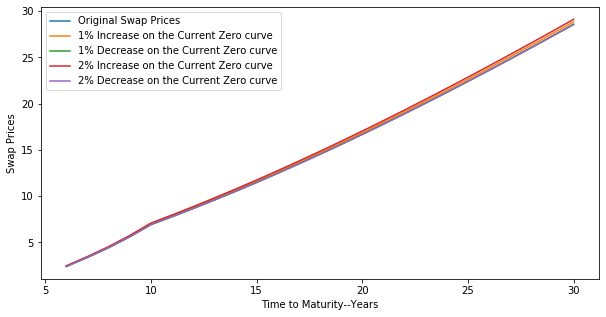

In [53]:
plt.figure(figsize=(10,5))    
plt.plot(range(6,31), NPV1, label = 'Original Swap Prices ')
plt.plot(range(6,31), NPV10BPS, label = '1% Increase on the Current Zero curve')
plt.plot(range(6,31), NPV_10BPS, label = '1% Decrease on the Current Zero curve')
plt.plot(range(6,31), NPV20BPS, label = '2% Increase on the Current Zero curve')
plt.plot(range(6,31), NPV_20BPS, label = '2% Decrease on the Current Zero curve')
plt.ylabel('Swap Prices')
plt.xlabel('Time to Maturity--Years')
plt.legend()
plt.show()

In [40]:
# we shock the Zero Rate by increase 1%
IRS1.ShockCurves(0.01)
NPV10Bps = IRS1.calSwapValue()
NPV10Bps


28.83575125848419

In [14]:
ZRates = IRS0.ZRates
OIS = IRS0.OIS
Ts = IRS0.Ts
#plt

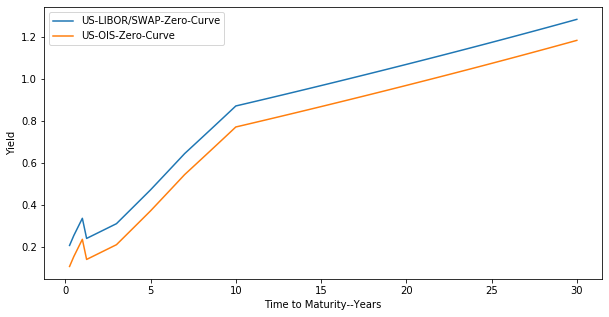

In [19]:
plt.figure(figsize=(10,5))    
plt.plot(Ts, ZRates*100, label = 'US-LIBOR/SWAP-Zero-Curve')
plt.plot(Ts, OIS*100, label = 'US-OIS-Zero-Curve')
#plt.plot(TRs[:,0], TRs[:,1], label = 'US-LIBOR')
#plt.plot(TRs[:,0], TRs[:,1], label = 'US-LIBOR-SWAP')
plt.ylabel('Yield')
plt.xlabel('Time to Maturity--Years')
plt.legend()
plt.show()